In [45]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [46]:
train_df = pd.read_csv(cf.train_file_path, sep='\t')
# A
test_df = pd.read_csv(cf.testA_file_path, sep='\t')
# B
test_df = test_df.append(pd.read_csv(cf.testB_file_path, sep='\t'))

In [47]:
def fix_data_date(df, last_dow, start_date):
    fix_rows = []
    fix_date = 0
    fix_columns = np.append(df.columns.values, 'date_fix')
    is_train = 'cnt' in fix_columns
    for i, row in df.iterrows():
        curr_dow = row['day_of_week']
        while curr_dow - last_dow > 1 or -6 < curr_dow - last_dow <= 0:
            last_dow = last_dow + 1 if last_dow < 7 else 1
            fix_date += 1
            if is_train:
                fix_rows.append(np.array([-1, 0, last_dow, start_date + timedelta(days=fix_date)]))
            else:
                fix_rows.append(np.array([-1, last_dow, start_date + timedelta(days=fix_date)]))
        last_dow = curr_dow
        fix_date += 1
        fix_rows.append(np.append(row.values, start_date + timedelta(days=fix_date)))
    new_df = pd.DataFrame(fix_rows, columns=fix_columns)
    return new_df

# process train date
start_train_date = datetime(2013,1,1)
train_cnt_df = train_df.groupby('date', as_index=False)['cnt'].sum()
train_cnt_df = train_cnt_df.merge(train_df[['date', 'day_of_week']].drop_duplicates(), on='date')
train_new_df = fix_data_date(train_cnt_df, 2, start_train_date)
# process test date
start_test_date = train_new_df.iloc[-1,-1] - timedelta(days=1)
last_dow = train_new_df.iloc[-1,-2] - 1
test_new_df = fix_data_date(test_df, last_dow, start_test_date)
# A
#test_new_df = test_new_df.append(pd.DataFrame([[-1,3,datetime(2017,3,1)]], columns=test_new_df.columns.values))
# B
test_new_df = test_new_df.append(pd.DataFrame([[-1,3,datetime(2017,11,29)]], columns=test_new_df.columns.values))
test_new_df = test_new_df.append(pd.DataFrame([[-1,4,datetime(2017,11,30)]], columns=test_new_df.columns.values))

##### 1. devide raw data into month trend and daily factor.

In [48]:
# process train data
train_new_df['month'] = train_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
train_fix_df = train_new_df.loc[train_new_df['month'] < '20160401']
train_fix_df.to_csv(cf.train_fix_file_path)
frame_sum = train_fix_df.groupby('month')['cnt'].sum()
frame_sum.name = 'month_sum'
frame_days = train_fix_df.loc[train_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
frame_mean = frame_sum / frame_days
frame_mean.name = 'month_mean'
train_fix_df = train_fix_df.merge(frame_sum.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_days.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_mean.reset_index(), on='month')
train_fix_df.set_index('date_fix', inplace=True)
# process test data
test_new_df['month'] = test_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
test_fix_df = test_new_df
test_fix_df.to_csv(cf.test_fix_file_path)
frame_days = test_fix_df.loc[test_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
# fix last day
# A
#frame_days[-1] = 21
test_fix_df = test_fix_df.merge(frame_days.reset_index(), on='month', how='left')
test_fix_df.set_index('date_fix', inplace=True)

##### 2. First Predict monthly trend

(-3.9954662786868909, 0.0014344380937124652, 1, 25, {'5%': -2.98648896, '1%': -3.7238633119999998, '10%': -2.6328003999999998}, 3.389007044871196)


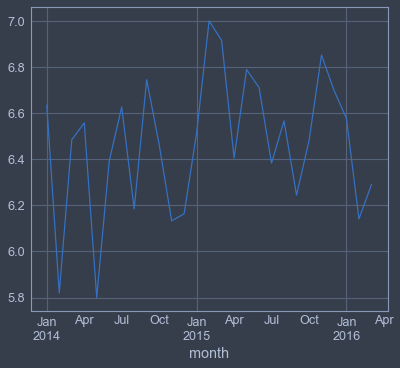

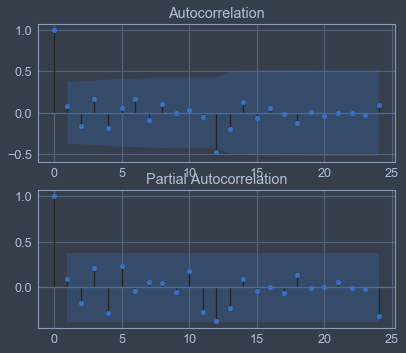

In [49]:
#
ts = frame_mean.diff(12)
# deal with neg values and use log to reduce amplitude
ts = np.log(ts+500)
ts.dropna(inplace=True)
# fix sample with huge diff
ts[4] = 5.8
ts[13] = 7.0
ts.plot()

f = plt.figure()
ax1 = f.add_subplot(211)
plot_acf(ts, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(ts, lags=24, ax=ax2)

print adfuller(ts)

                              ARMA Model Results                              
Dep. Variable:             month_mean   No. Observations:                   27
Model:                     ARMA(6, 1)   Log Likelihood                  -0.906
Method:                       css-mle   S.D. of innovations              0.242
Date:                Sat, 24 Feb 2018   AIC                             19.813
Time:                        17:44:21   BIC                             31.476
Sample:                    01-01-2014   HQIC                            23.281
                         - 03-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.4643      0.066     97.432      0.000       6.334       6.594
ar.L1.month_mean    -0.6259      0.208     -3.006      0.007      -1.034      -0.218
ar.L2.month_mean    -0.0656 

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


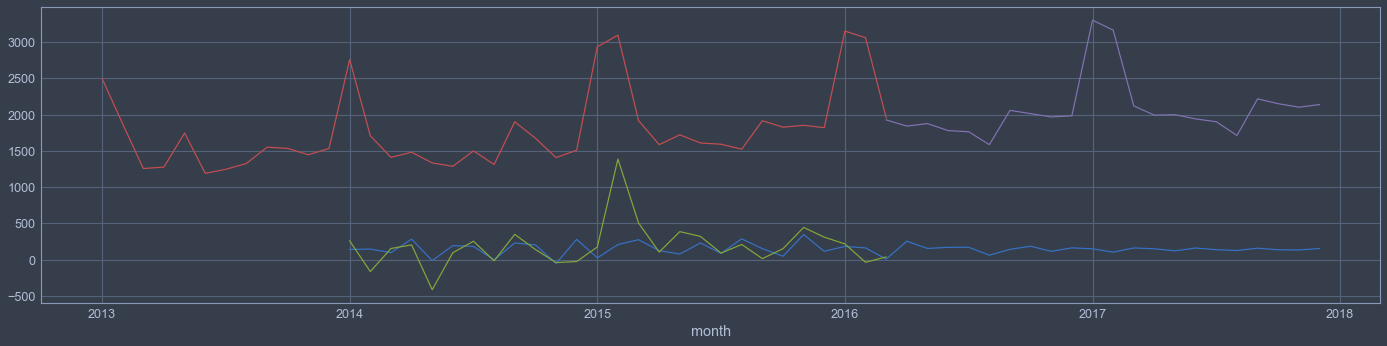

In [50]:
#
f = plt.figure(figsize=(24,12))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)
model = ARMA(ts, order=(6, 1)) 
result_arma = model.fit(disp=-1)
#result_arma.plot_predict(start='2014-08-01', ax=ax1)
print result_arma.summary()

# recover predict value
predict_values = result_arma.predict(end='2017-12-1')
# log recover
predict_values = np.exp(predict_values) - 500

predict_values.plot()
frame_mean.diff(12).plot()


frame_mean_ext = frame_mean.append(pd.Series(index=pd.date_range('2016-04','2017-03',freq='MS')))
# calculate feature 2 years month brand value.
pred_ts = (frame_mean_ext.shift(12) + predict_values).dropna()

pred_ts_ext = pred_ts.append(pd.Series(index=pd.date_range('2017-04','2017-12',freq='MS'))).shift(12)[-12:] + predict_values
pred_ts = pred_ts.append(pred_ts_ext[-9:])

frame_mean_ext.plot()
pred_ts[pred_ts.index>'2016-02'].plot()

##### 2. predict daily factor.

In [51]:
import xgboost
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [52]:
def process_features(df):
    # add month infos.
    df.loc[:,'month_of_year'] = df.index.map(lambda x: x.month)
    df.loc[:,'day_of_month'] = df.index.map(lambda x: 1 if x.day < 11 else 2 if x.day < 21 else 3)
    # add holiday infos.
    df.loc[:,'is_holiday'] = df.index.map(lambda x: 1 if is_holiday(x.date()) else 0)
    df.loc[:,'is_day_off'] = df[['is_holiday','day_of_week']].apply(lambda x: 1 if not x[0] and x[1] > 5 else 0, axis=1)
    ext_feature_list = ['after_holiday', 'after_holiday_1', 'after_holiday_2',
                        'before_holiday', 'before_holiday_1', 'before_holiday_2']
    df = df.join(pd.DataFrame(0, df.index, ext_feature_list))
    last_holidays = 0
    for index, row in df.iterrows():
        if row['is_holiday']:
            last_holidays += 1
        else:
            # law holiday
            if last_holidays > 2:
                holiday_long = 1 if last_holidays > 3 else 0.5
                df.loc[index, 'after_holiday'] = holiday_long
                before_index = index - timedelta(days=last_holidays + 1)
                if before_index in df.index:
                    df.loc[before_index, 'before_holiday'] = holiday_long
                i = 1
                after_ext_index = index + timedelta(days=1)
                while i < 3 and after_ext_index in df.index:
                    if df.loc[after_ext_index, 'is_holiday']:
                        after_ext_index = after_ext_index + timedelta(days=1)
                        continue
                    df.loc[after_ext_index, 'after_holiday_%d' % i] = holiday_long
                    i += 1
                    after_ext_index = after_ext_index + timedelta(days=1)
                i = 1
                before_ext_index = before_index - timedelta(days=1)
                while i < 3 and before_ext_index in df.index:
                    if df.loc[before_ext_index, 'is_holiday']:
                        before_ext_index = before_ext_index - timedelta(days=1)
                        continue
                    df.loc[before_ext_index, 'before_holiday_%d' % i] = holiday_long
                    i += 1
                    before_ext_index = before_ext_index - timedelta(days=1)
            last_holidays = 0
    # day before holiday or after holiday infos
    df = df.join(pd.get_dummies(df['day_of_week'], prefix='day_of_week'))
    #df = df.join(pd.get_dummies(df['day_of_month'], prefix='day_of_month'))
    #df = df.join(pd.get_dummies(((df['month_of_year'] + 1) / 2).astype(int), prefix='month_of_year'))
    df = df.join(pd.get_dummies(df['month_of_year'], prefix='month_of_year'))
    # add holiday type
    frame = pd.Series(map(lambda x, a1, a2, a3, b1, b2, b3: 1 if x < 6 and (a1 or a2 or a3 or b1 or b2 or b3) else 0,
                      df['month_of_year'], df['after_holiday'], df['after_holiday_1'], df['after_holiday_2'],
                      df['before_holiday'], df['before_holiday_1'], df['before_holiday_2']))
    frame.name = 'spring_festeval'
    frame.index = df.index
    df = df.join(frame)
    frame = pd.Series(map(lambda x, a1, a2, a3, b1, b2, b3: 1 if x > 7 and (a1 or a2 or a3 or b1 or b2 or b3) else 0,
                      df['month_of_year'], df['after_holiday'], df['after_holiday_1'], df['after_holiday_2'],
                      df['before_holiday'], df['before_holiday_1'], df['before_holiday_2']))
    frame.name = 'national_day'
    frame.index = df.index
    df = df.join(frame)
    return df

In [53]:
train_proc_df = process_features(train_fix_df)
test_proc_df = process_features(test_fix_df)
# labels
train_proc_df.loc[:,'day_factor'] = train_proc_df['cnt'] / train_proc_df['month_mean']
# date split
train_valid_df = train_proc_df.iloc[train_proc_df.index < '2014']
train_proc_df = train_proc_df.iloc[train_proc_df.index >= '2014']


# 取出训练集的y
train_y = train_proc_df.iloc[:,-1]
train_X = train_proc_df.iloc[:,9:-1]
test_X = test_proc_df.iloc[:,6:]
valid_y = train_valid_df.iloc[:,-1]
valid_X = train_valid_df.iloc[:,9:-1]

MSE: 229872.945855
MSE: 270023.923811


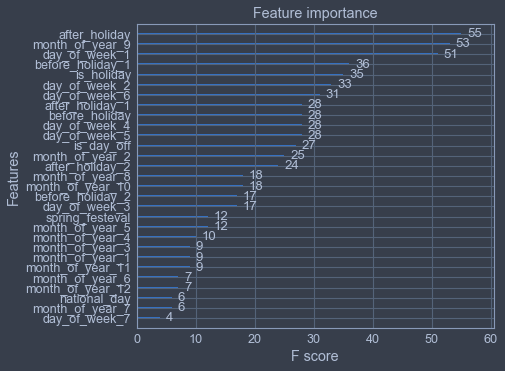

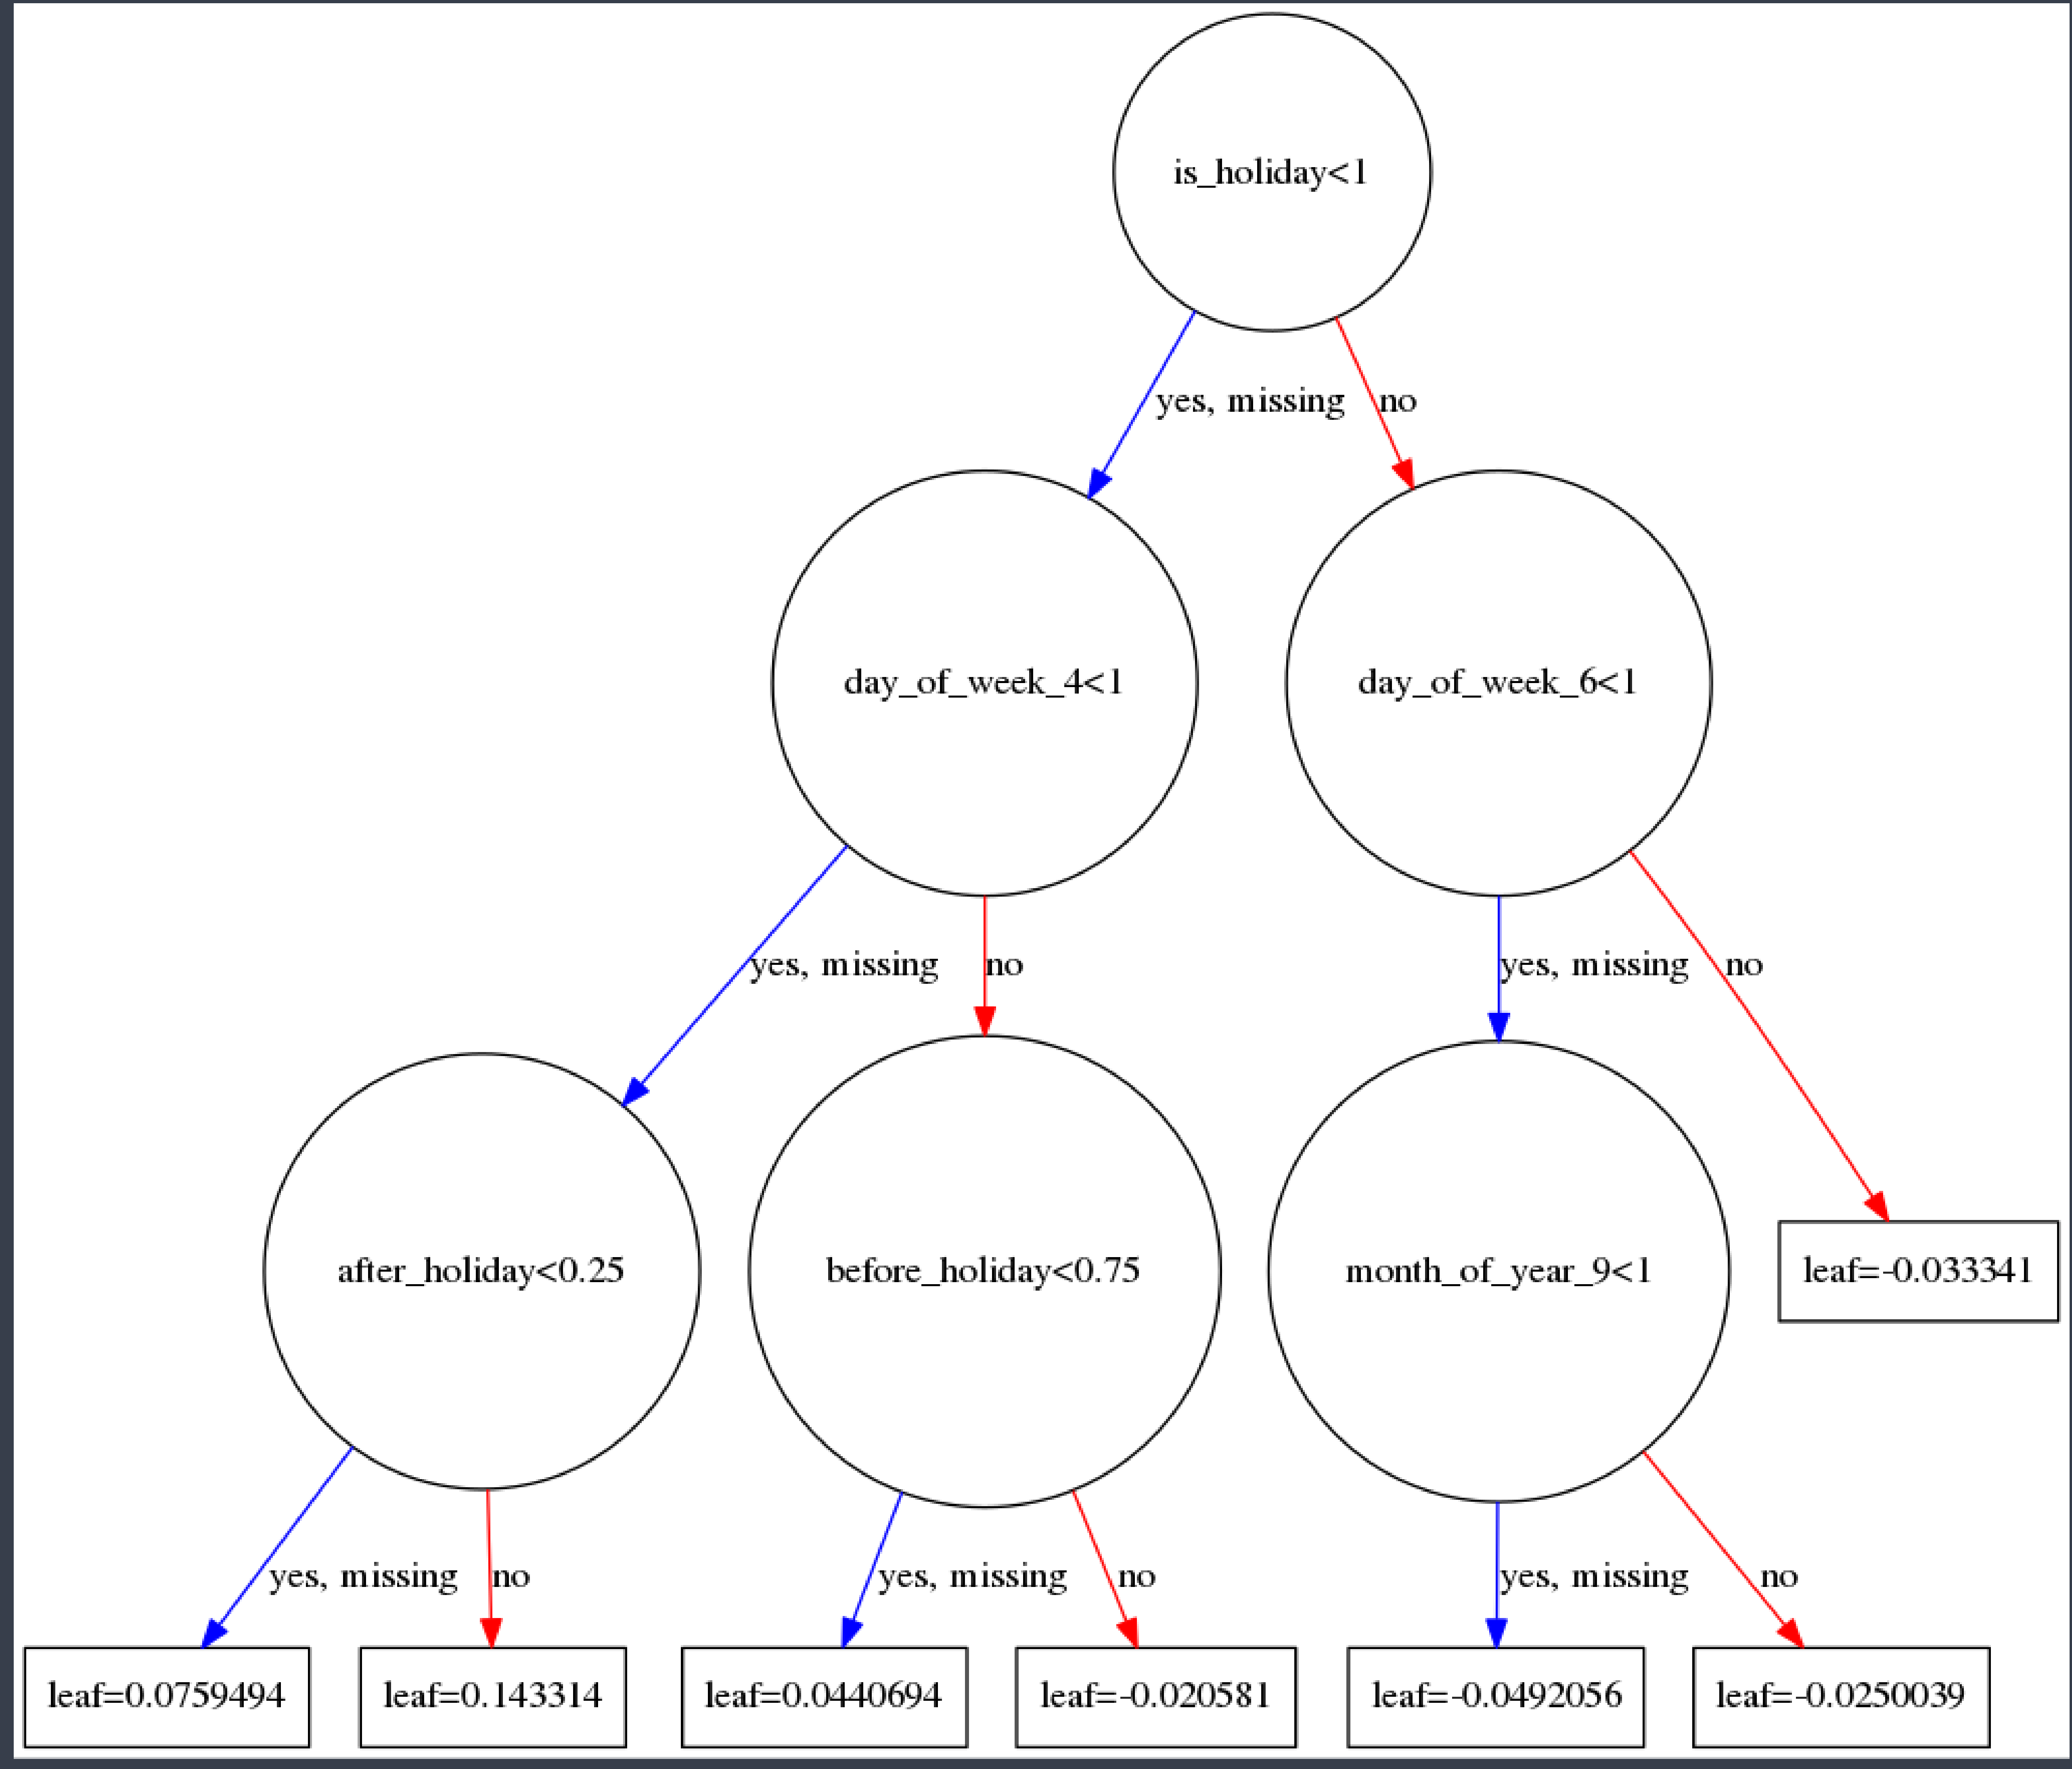

In [54]:
# 建立一个默认的xgboost回归模型
reg = xgboost.XGBRegressor(max_depth=3)
reg.fit(train_X, train_y)
xgboost.plot_importance(reg)
xgboost.plot_tree(reg)
fig = plt.gcf()
fig.set_size_inches(120, 80)
#fig.savefig('tree.png')
# 验证
y_pred= reg.predict(valid_X)
frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)

frame_days = pred_df.groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_df = pred_df.join(frame_days, on='month')
#pred_df.loc[pred_df['month']=='2017-02-01', 'month_days'] = 14

print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'] * pred_df['month_days'] / pred_df['month_days_pred'], frame * pred_df['month_mean'])

In [55]:
# train weight
reg1 = xgboost.XGBRegressor(max_depth=3)
reg1.fit(train_X.iloc[train_X.index<'2015'], train_y.iloc[train_y.index<'2015'])

reg2 = xgboost.XGBRegressor(max_depth=3)
reg2.fit(train_X.iloc[train_X.index>='2015'], train_y.iloc[train_y.index>='2015'])

y_pred1 = reg1.predict(valid_X)
y_pred2 = reg2.predict(valid_X)
y_pred = y_pred1 / 3 + y_pred2 * 2 / 3
frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)

frame_days = pred_df.groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_df = pred_df.join(frame_days, on='month')
#pred_df.loc[pred_df['month']=='2017-02-01', 'month_days'] = 14

print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'] * pred_df['month_days'] / pred_df['month_days_pred'], frame * pred_df['month_mean'])

MSE: 225061.79971
MSE: 270566.411303


In [56]:
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = model.predict(valid_X)

frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])

#print pd.DataFrame(model.coef_, columns=train_X.columns.values)
print train_X.columns.values
print model.coef_

MSE: 245559.939323
['is_holiday' 'is_day_off' 'after_holiday' 'after_holiday_1'
 'after_holiday_2' 'before_holiday' 'before_holiday_1' 'before_holiday_2'
 'day_of_week_1' 'day_of_week_2' 'day_of_week_3' 'day_of_week_4'
 'day_of_week_5' 'day_of_week_6' 'day_of_week_7' 'month_of_year_1'
 'month_of_year_2' 'month_of_year_3' 'month_of_year_4' 'month_of_year_5'
 'month_of_year_6' 'month_of_year_7' 'month_of_year_8' 'month_of_year_9'
 'month_of_year_10' 'month_of_year_11' 'month_of_year_12' 'spring_festeval'
 'national_day']
[ -1.14823595e+00  -3.19232563e-01   1.05782990e+00   3.77241562e-01
   2.38367251e-01  -2.98922026e-01  -2.77984426e-02  -7.08217425e-02
   4.90968211e+12   4.90968211e+12   4.90968211e+12   4.90968211e+12
   4.90968211e+12   4.90968211e+12   4.90968211e+12  -7.02891517e+12
  -7.02891517e+12  -7.02891517e+12  -7.02891517e+12  -7.02891517e+12
  -7.02891517e+12  -7.02891517e+12  -7.02891517e+12  -7.02891517e+12
  -7.02891517e+12  -7.02891517e+12  -7.02891517e+12   1.39566

In [57]:
model = RandomForestRegressor(n_estimators=8)
model.fit(train_X, train_y)
y_pred = model.predict(valid_X)

frame = pd.Series(y_pred, index=valid_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = train_fix_df.iloc[train_fix_df.index < '2014'].join(frame)
print "MSE:", mean_squared_error(valid_y * pred_df['month_mean'], frame * pred_df['month_mean'])

#print pd.DataFrame(model.coef_, columns=train_X.columns.values)
print train_X.columns.values
#print model.coef_

MSE: 266627.825022
['is_holiday' 'is_day_off' 'after_holiday' 'after_holiday_1'
 'after_holiday_2' 'before_holiday' 'before_holiday_1' 'before_holiday_2'
 'day_of_week_1' 'day_of_week_2' 'day_of_week_3' 'day_of_week_4'
 'day_of_week_5' 'day_of_week_6' 'day_of_week_7' 'month_of_year_1'
 'month_of_year_2' 'month_of_year_3' 'month_of_year_4' 'month_of_year_5'
 'month_of_year_6' 'month_of_year_7' 'month_of_year_8' 'month_of_year_9'
 'month_of_year_10' 'month_of_year_11' 'month_of_year_12' 'spring_festeval'
 'national_day']


In [58]:
# 预测
y_pred = reg.predict(test_X)
frame_pred = pd.Series(y_pred, index=test_X.index)
frame_pred.map(lambda x:x if x > 0 else 0)
frame_pred.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = test_fix_df.join(frame_pred)

In [59]:
# 预测 weight
y_pred1 = reg1.predict(test_X)
y_pred2 = reg2.predict(test_X)
y_pred = y_pred1 / 3 + y_pred2 * 2 / 3
frame_pred = pd.Series(y_pred, index=test_X.index)
frame_pred.map(lambda x:x if x > 0 else 0)
frame_pred.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = test_fix_df.join(frame_pred)

In [60]:
# 预测结果组合
frame = pred_ts
frame.name = 'month_mean'
pred_cb_df = pred_df.join(frame, on='month')

#print pred_cb_df.groupby('month').sum()['pred']
frame_days = pred_cb_df.loc[pred_cb_df['date']>0].groupby('month').sum()['pred']
frame_days.name = 'month_days_pred'
pred_cb_df = pred_cb_df.join(frame_days, on='month')
pred_cb_df.loc[pred_cb_df['month']=='2017-02-01', 'month_days'] = 14

#pred_cb_df.loc[:, 'predict'] = pred_cb_df['month_mean'] * pred_cb_df['pred']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['month_mean'] * pred_cb_df['pred'] * pred_cb_df['month_days'] / pred_cb_df['month_days_pred']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['predict'].map(lambda x:x if x > 0 else 0)

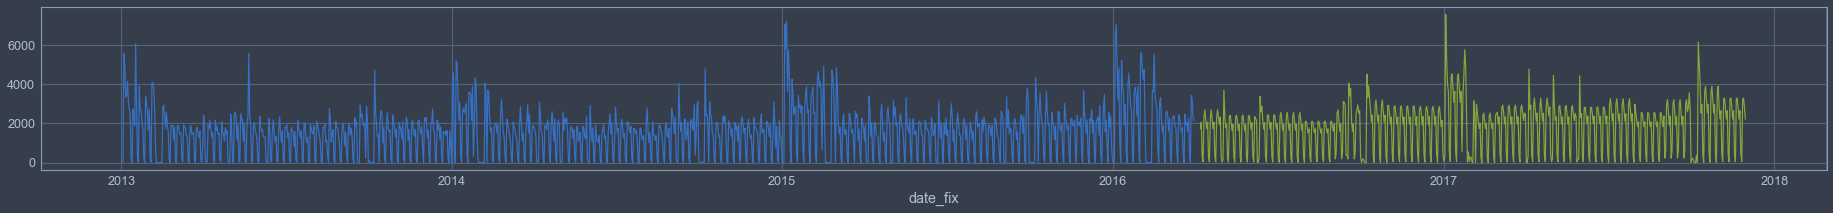

In [61]:
train_fix_df['cnt'].plot(figsize=(32,3))
pred_cb_df['predict'].plot(figsize=(32,3))
pred_cb_df.loc[pred_cb_df['date']>0][['date', 'predict']].astype(int).to_csv('test.csv', sep='\t', index=False, header=False)
pred_cb_df[['date', 'day_of_week', 'predict']].to_csv('test_fix.csv')

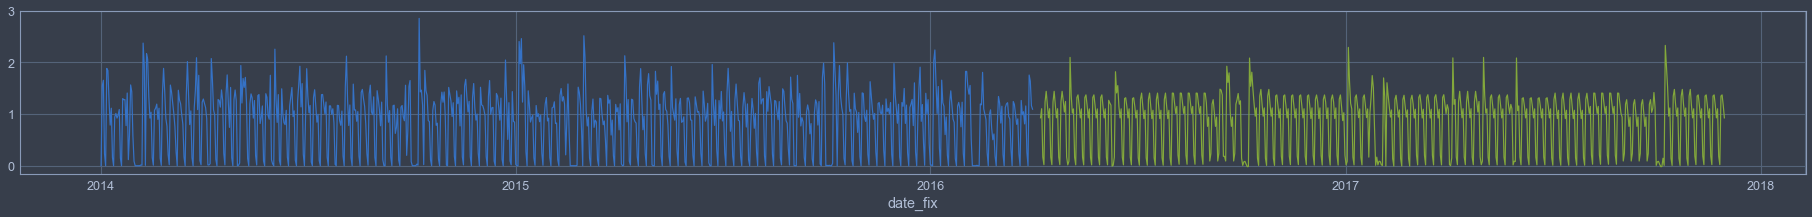

In [62]:
pred_cb_df[['month', 'month_days', 'month_days_pred']].drop_duplicates()
train_proc_df['day_factor'].plot(figsize=(32,3))
frame_pred.plot()